# 2020 SEG Annual Meeting Machine Learning Interpretation Workshop

In [1]:
import os  
import numpy as np
from time import time

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

import tensorflow.keras.backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import architecture as a
import data as d
from PatchExtractor import PatchExtractor as PE
from utils import normalize_only, normalize

seed = 0
np.random.seed(seed)

#Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Plotting library
from matplotlib import pyplot as plt
from matplotlib import rcParams
from plotting import plot_label
from mpl_toolkits.axes_grid1 import make_axes_locatable

rcParams.update({
    'image.cmap'     : 'gray',
    'axes.grid'      : False,
    'savefig.dpi'    : 300,  # to adjust notebook inline plot size
    'axes.labelsize' : 14,  # fontsize for x and y labels (was 10)
    'axes.titlesize' : 14,
    'font.size'      : 14,
    'legend.fontsize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'text.usetex'    : True
})

In [2]:
CLASS_NAMES = ["Basement", "SlopeMudA", "Deposit", "SlopeMudB", "SlopeValley", "Canyon"]
num_classes = len(CLASS_NAMES)
dataset = "/nas/public/dataset/geophysics/BlindTestSEG/"
num_sections = 128

In [3]:
image = np.load(os.path.join(dataset, "train_image.npy"))[:,:num_sections,:]
label = np.load(os.path.join(dataset, "train_labels.npy"))[:,:num_sections,:].astype(np.uint8)-1

In [4]:
print('x\ty\tz')
print('%d\t%d\t%d' % (image.shape[0],image.shape[1],image.shape[2]))

x	y	z
590	128	1006


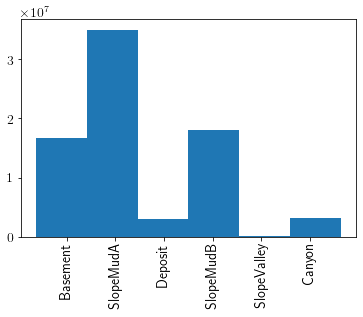

In [5]:
plt.hist(label.ravel(), 6)
plt.xticks(np.linspace(0.5,4.5,num_classes), CLASS_NAMES, rotation=90)
plt.show()

## UNet-like 2D

In [6]:
pe = PE(dim=(992,128), stride=(2,32))

In [7]:
patches_img = []
patches_msk = []
for inline in range(image.shape[1]):
    patches_img.append(pe.extract(image[:,inline].T))
    patches_msk.append(pe.extract(label[:,inline].T))
    
patches_img = np.asarray(patches_img).reshape((-1,)+pe.dim+(1,))
patches_msk = np.asarray(patches_msk).reshape((-1,)+pe.dim+(1,))

In [8]:
patches_img.shape

(15360, 992, 128, 1)

Normalize the image in $[-1,1]$

In [9]:
patches_img, in_min, in_max = normalize(patches_img)

In [10]:
patches_msk = to_categorical(patches_msk)

In [11]:
patches_msk.shape

(15360, 992, 128, 6)

Divide into train and validation

In [12]:
bound = patches_img.shape[0]//2

In [13]:
train_img, val_img = patches_img[:bound], patches_img[bound:]

In [14]:
train_msk_cls, val_msk_cls = patches_msk[:bound], patches_msk[bound:]

In [15]:
train_msk_cls.shape

(7680, 992, 128, 6)

#### Model

In [16]:
# Build model
K.clear_session()
model = a.Xception(pe.dim+(1,), num_classes=num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 992, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 496, 64, 32)  320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 496, 64, 32)  128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 496, 64, 32)  0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [17]:
model.compile(optimizer="rmsprop", loss='bce')

In [33]:
callbacks = [
    ModelCheckpoint("test1_weights.h5", save_best_only=True),
    # EarlyStopping(patience=5),
]

In [34]:
history = model.fit(train_img, train_msk_cls,
                    validation_data=(val_img, val_msk_cls),
                    epochs=20, callbacks=callbacks, verbose=1)

Train on 7680 samples, validate on 7680 samples
Epoch 1/20
7680/7680 [==============================] - 254s 33ms/sample - loss: 0.1518 - val_loss: 1.0827
Epoch 2/20
7680/7680 [==============================] - 227s 30ms/sample - loss: 0.0288 - val_loss: 1.2525
Epoch 3/20
7680/7680 [==============================] - 228s 30ms/sample - loss: 0.0167 - val_loss: 0.1297
Epoch 4/20
7680/7680 [==============================] - 227s 30ms/sample - loss: 0.0115 - val_loss: 0.0634
Epoch 5/20
7680/7680 [==============================] - 227s 30ms/sample - loss: 0.0123 - val_loss: 0.0700
Epoch 6/20
7680/7680 [==============================] - 227s 30ms/sample - loss: 0.0074 - val_loss: 0.0733
Epoch 7/20
7680/7680 [==============================] - 227s 30ms/sample - loss: 0.0062 - val_loss: 0.0514
Epoch 8/20
7680/7680 [==============================] - 228s 30ms/sample - loss: 0.0067 - val_loss: 0.0689
Epoch 9/20
7680/7680 [==============================] - 227s 30ms/sample - loss: 0.0050 - val_lo

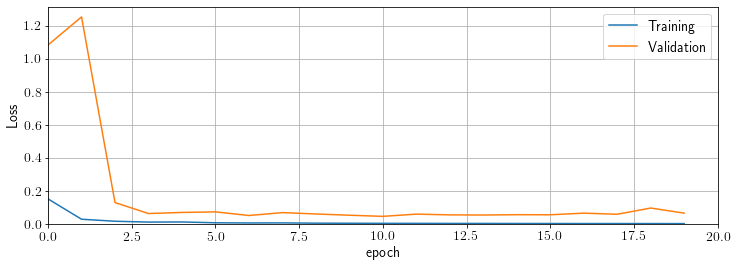

In [48]:
plt.figure(figsize=(12,4))
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.xlim(0,20)
plt.ylim(0)
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

## Visualize

In [18]:
model.load_weights("test1_weights.h5")

In [19]:
img, msk = train_img[0], train_msk_cls[0],
out = model.predict(img[np.newaxis]).squeeze()

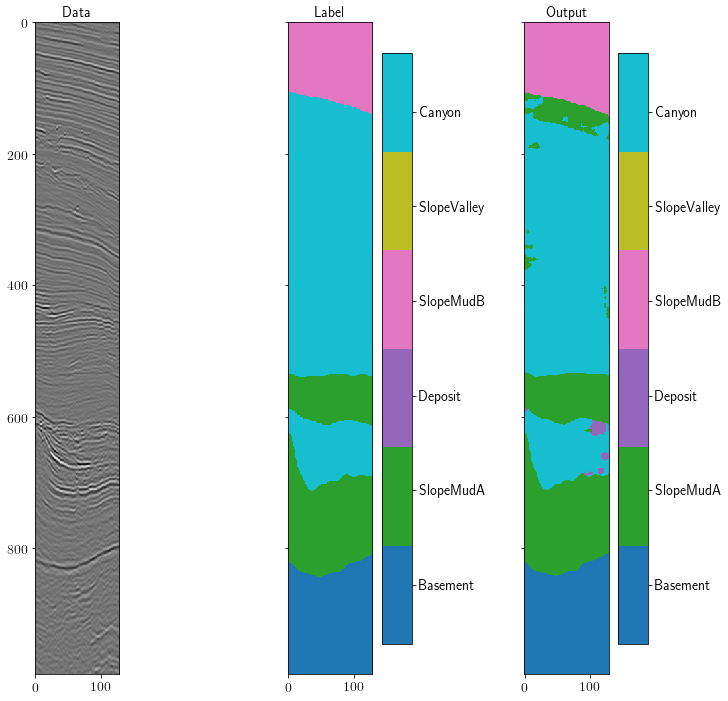

In [20]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(12, 12))

data=axs[0].imshow(img.squeeze())
axs[0].set_title('Data')

plot_label(np.argmax(msk, axis=-1),
           fig, axs[1], num_classes, labels=CLASS_NAMES)
axs[1].set_title('Label')

plot_label(np.argmax(out, axis=-1).squeeze(),
           fig, axs[2], num_classes, labels=CLASS_NAMES)
axs[2].set_title('Output')

plt.show()

In [21]:
img, msk = val_img[0], val_msk_cls[0],
out = model.predict(img[np.newaxis]).squeeze()

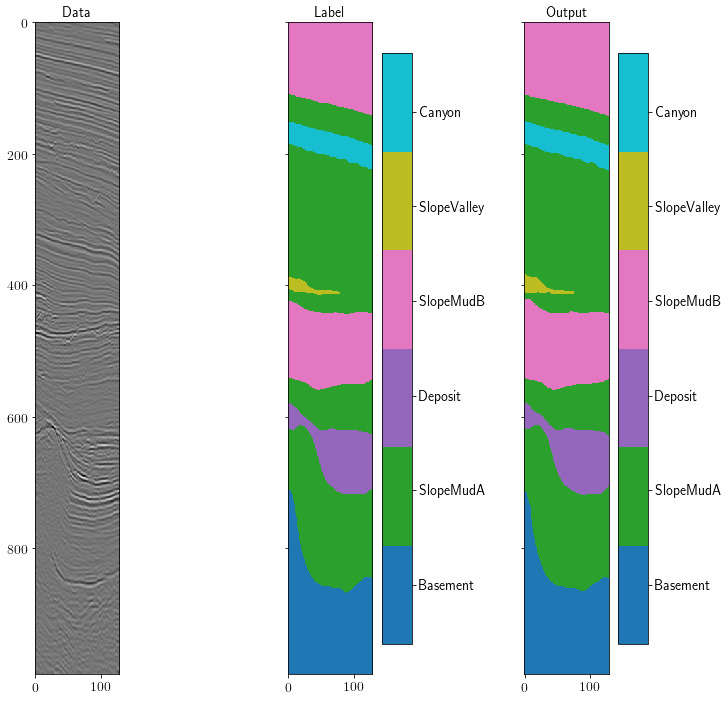

In [22]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(12, 12))

data=axs[0].imshow(img.squeeze())
axs[0].set_title('Data')

plot_label(np.argmax(msk, axis=-1),
           fig, axs[1], num_classes, labels=CLASS_NAMES)
axs[1].set_title('Label')

plot_label(np.argmax(out, axis=-1).squeeze(),
           fig, axs[2], num_classes, labels=CLASS_NAMES)
axs[2].set_title('Output')

plt.show()

## Test

In [23]:
test_image = np.load(os.path.join(dataset, "train_image.npy"))[:,-1,:]
test_label = np.load(os.path.join(dataset, "train_labels.npy"))[:,-1,:].astype(np.uint8)-1

In [24]:
patch_img = pe.extract(test_image.T).reshape((-1,)+pe.dim+(1,))
patch_msk = pe.extract(test_label.T).reshape((-1,)+pe.dim+(1,))

In [30]:
patch_out = model.predict(normalize(patch_img, in_min, in_max)[0])

In [36]:
patch_out_max = np.argmax(patch_out, axis=-1)

In [38]:
out = pe.reconstruct(patch_out_max.reshape(pe.patch_array_shape))

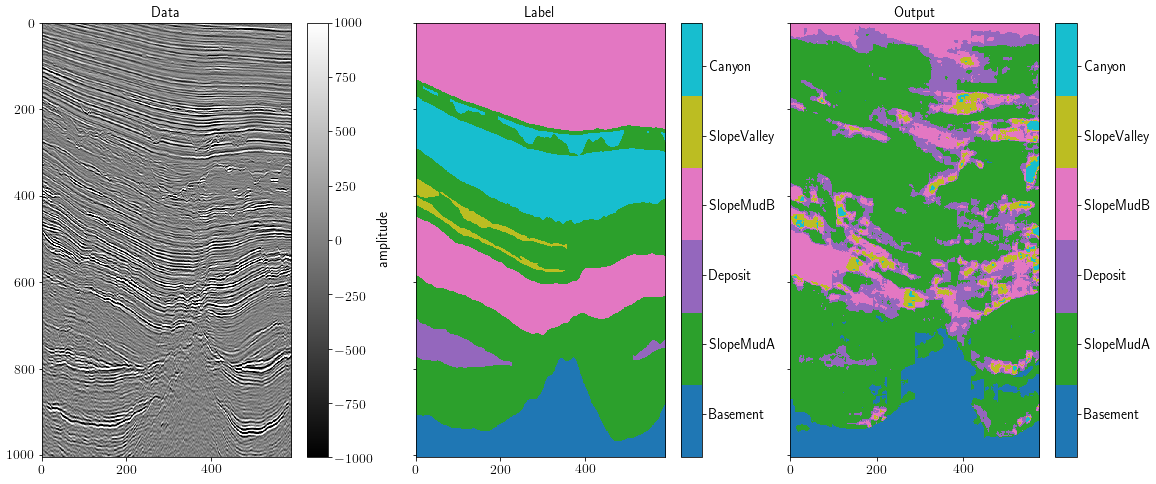

In [48]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(19, 8))

data=axs[0].imshow(test_image.T, clim=(-1000,1000))
axs[0].set_title('Data')
axs[0].axis('tight')
fig.colorbar(data, ax=axs[0],  label='amplitude')

plot_label(test_label.T, fig, axs[1], num_classes, labels=CLASS_NAMES, cmap='tab10')
axs[1].set_title('Label')
axs[1].axis('tight')

plot_label(out, fig, axs[2], num_classes, labels=CLASS_NAMES, cmap='tab10')
axs[2].set_title('Output')
axs[2].axis('tight')
           
plt.show()